In [1]:
import pandas as pd
import numpy as np

In [2]:
corpus_df = pd.read_csv("res/pan2malay.csv")

```
1, aba, aba-h
2, abaŋ, abaŋ-an
...
```

↓

`[aba, aba-h, abaŋ, abaŋ-an...]`

↓

`abaaba-habaŋabaŋ-an...`

↓

then get all the unique characters

In [3]:
def get_char_set():
    without_index = np.delete(corpus_df.to_numpy(), 0, 1)
    flat = without_index.flatten().astype("str")
    giant_string = "".join(flat)
    return set(giant_string)

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
encoder_mapping = list(get_char_set())
one_hot = tf.eye(len(encoder_mapping))

def encode(c):
    return one_hot[encoder_mapping.index(c)]

def decode(arr):
    return encoder_mapping[np.argmax(arr)]

vec_of_ng = encode("ŋ")
print(vec_of_ng)
print(decode(vec_of_ng))

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], shape=(52,), dtype=float32)
ŋ


Make the function for en/decoding a list of strings

In [6]:
WORD_MAX_LEN = 64

def text_encoder(doc):
    encoded = []
    for word in doc:
        word_matrix = tf.stack([encode(c) for c in word.ljust(WORD_MAX_LEN, " ")])
        encoded.append(word_matrix.numpy().reshape((WORD_MAX_LEN, len(encoder_mapping), 1)))
    return np.stack(encoded, 0)

def text_decoder(matrix_list):
    decoded = []
    for m in np.split(matrix_list, matrix_list.shape[0], 0):
        reshaped = m.reshape((WORD_MAX_LEN, len(encoder_mapping)))
        guess = "".join([decode(reshaped[i]) for i in range(WORD_MAX_LEN)])
        decoded.append(str.strip(guess))
    return decoded

print(corpus_df["pan"][:5])
doc_encoding_example = text_encoder(corpus_df["pan"][:5])
print("\nencode batch of words into matrix")
print(doc_encoding_example.shape)
print(doc_encoding_example)
doc_decoding_example = text_decoder(doc_encoding_example)
print("\ninterpret the guess matrix back into word")
print(doc_decoding_example)

0     aba
1    abaŋ
2     adu
3    aduq
4    agas
Name: pan, dtype: object

encode batch of words into matrix
(5, 64, 52, 1)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  

In [104]:
model = keras.Sequential()
model.add(keras.Input(shape=(WORD_MAX_LEN, len(encoder_mapping), 1)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(8, (3,3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(8, (3,3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(8, (3,3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(1, (3,3), activation="sigmoid", padding="same"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 64, 52, 1)         0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 52, 8)         80        
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 52, 8)         584       
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 52, 8)         584       
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 52, 1)         73        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [105]:
from sklearn.utils import shuffle

shuffled_corpus = shuffle(corpus_df).dropna()#[:int(0.2 * corpus_df.shape[0])]
train = shuffled_corpus[:int(0.9 * shuffled_corpus.shape[0])]
test = shuffled_corpus[int(0.9 * shuffled_corpus.shape[0]):]

model.fit(
    text_encoder(train["pan"]), 
    text_encoder(train["malay"]), 
    epochs=5, batch_size=30, validation_split=0.3)

Epoch 1/5
38/38 [==============================] - 5s 98ms/step - loss: 0.5884 - accuracy: 0.9813 - val_loss: 0.3250 - val_accuracy: 0.9808
Epoch 2/5
38/38 [==============================] - 4s 101ms/step - loss: 0.1172 - accuracy: 0.9838 - val_loss: 0.0240 - val_accuracy: 0.9977
Epoch 3/5
38/38 [==============================] - 3s 92ms/step - loss: 0.0188 - accuracy: 0.9965 - val_loss: 0.0120 - val_accuracy: 0.9978
Epoch 4/5
38/38 [==============================] - 3s 90ms/step - loss: 0.0138 - accuracy: 0.9971 - val_loss: 0.0110 - val_accuracy: 0.9978
Epoch 5/5
38/38 [==============================] - 3s 91ms/step - loss: 0.0131 - accuracy: 0.9973 - val_loss: 0.0106 - val_accuracy: 0.9978


In [106]:
pd.DataFrame({
    "Question": test["pan"].to_list(),
    "Prediction": text_decoder(
        model.predict(text_encoder(test["pan"]))),
    "CorrectAnswer": test["malay"].to_list()
}).query('Prediction != CorrectAnswer')

6/6 [==============================] - 0s 17ms/step


,Question,Prediction,CorrectAnswer
0,Raya,aaaa,raya
1,akaR,aaa,akar
2,su(ŋ)kab,su((ŋka,suŋkap
3,sendet,eeeee,tər-səndat
4,qatay qatay,aaaaaaaaaa,hati-hati
...,...,...,...
176,tunas,tuus,tunas
177,taŋgiRi,aaagiii,təŋgíri
178,getes,eeeee,gəntas
179,sempit,ssmmi,səmpit


1/1 [==============================] - 0s 29ms/step


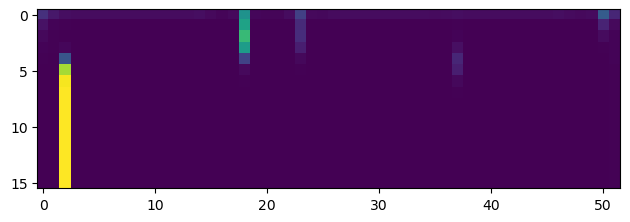

In [107]:
prediction = model.predict(text_encoder(test["pan"].sample(1))).reshape(WORD_MAX_LEN, len(encoder_mapping))

fig, ax = plt.subplots()
im = ax.imshow(prediction[:16])
fig.tight_layout()
plt.show()